In [1]:
from IPython.display import HTML

HTML('''
<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.input').show();
    } else {
        $('div.input').hide();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code"></form>''')

# K-Sparse Autoencoder

- Author: Tianchu Liang
- Date: May 3rd 2016

In this section, I will demonstrate my implementation on the K-Sparse Autoencoder. 

Our team uses the Fungus and Person datasets. In particular, for K-Sparse Autoencoder, I resized the images to 128 * 128 and transformed the images to grayscale. 

I used Caffe as the Neural Network framework; on top of that, I built from scratch a vanilla version of autoencoder first, which has the following architecture:

__Data ==> Encoding (Fully Connected Layer) ==> Sigmoid Activation Layer ==> Decoding (Fully Connected Layer) ==> Sigmoid Activation Layer ==> EuclideanLoss layer__

__With this plain and vanilla version of Autoencoder, I can use the Python interface in Caffe (demonstrated below) to do training iteration by iteration, and in the process, execute the K-sparse algorithm by intervening each training iteration. __

The corresponding .prototxt files can be found under '/code/Autoencoder' folder by the name of train_val_plain.prototxt and solver_plain.prototxt for training combined dataset, and train_val_person.prototxt,  solver_person.prototxt, train_val_fungus.prototxt, solver_fungus.prototxt for training separate datasets. 

For the purpose of demonstration, I have shown below the plain version prototxt of the autoencoder, of which I modified through Python Interface to implement the K-Sparse Algorithm: 

In [7]:
!cat /Users/tianchuliang/Documents/GT_Acad/CSE6240Spring16/tliang37-project2/code/Autoencoder/train_val_plain.prototxt

name: "KSparseAutoencoder"
layer {
  name: "data"
  type: "Data"
  top: "data"
  include {
    phase: TRAIN
  }
  transform_param {
    scale:0.001
    mean_file: "/Users/tianchuliang/Documents/GT_Acad/CSE6240Spring16/tliang37-project2/data/Train/train_mean.binaryproto"
  }
  data_param {
    source: "/Users/tianchuliang/Documents/GT_Acad/CSE6240Spring16/tliang37-project2/data/Train/fungus_person_train_lmdb"
    batch_size: 1
    backend: LMDB
  }
}
layer {
  name: "data"
  type: "Data"
  top: "data"
  include {
    phase: TEST
  }
  transform_param {
    scale:0.001
    mean_file: "/Users/tianchuliang/Documents/GT_Acad/CSE6240Spring16/tliang37-project2/data/Test/test_mean.binaryproto"
  }
  data_param {
    source: "/Users/tianchuliang/Documents/GT_Acad/CSE6240Spring16/tliang37-project2/data/Test/fungus_person_test_lmdb"
    batch_size: 1
    backend: LMDB
  }
}
layer {
  name: "flatdata"
  type: "Flatten"
  bottom: "data"
  top: "flatdata"
}
layer {
  name: "encode1"
  type: "InnerPr

In [1]:
code_root ='/Users/tianchuliang/Documents/GT_Acad/CSE6240Spring16/tliang37-project2/code' 
caffe_root = '/usr/local/caffe'
net_root = '/Users/tianchuliang/Documents/GT_Acad/CSE6240Spring16/tliang37-project2/code/Autoencoder'
data_root = '/Users/tianchuliang/Documents/GT_Acad/CSE6240Spring16/tliang37-project2/data'

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import caffe
from caffe import layers as L
from caffe import params as P
from pylab import *
import sys
sys.path.insert(0, caffe_root + '/python')

In [2]:
caffe.set_mode_cpu()

## K-Sparse Autoencoder

### Implementation Approach:

My implementation of K-Sparse is based on the Caffe CNN framework. The data comes into the network (architecture shown above) as gray-scale square images; then the image data gets flattened by a 'Flatten' Caffe layer. The flattened data then is a one dimensional vector. 

The one dimensional flattend vector then gets encoded by the 'encode1' layer. The activation layer is sigmoid function layer; it follows right after the 'encode1' layer. After the activation layer, the data is fed into the 'decode1' layer. After being processed by the 'decode1'layer

Below is the function k_sparse. 

In [3]:
from scipy.special import expit
from sklearn.metrics.pairwise import euclidean_distances
def k_sparse(solver,save_path,filename,k=70,niters=400):
    test_loss=[]
    test_itr = 50
    test_interval = 5
    train_loss = np.zeros((niters/test_interval))

#     For loop:
    for itr in range(niters):
#         Training net: do a forward pass
        solver.net.forward()
#             Find the first k largest activation values,
#             and recalculate the forward values through the rest of the network:
        inds = np.argsort(solver.net.blobs['encode1neuron'].data[...])[::-1][0,k:]
        weight_matrix = solver.net.params['decode1'][0].data[...]
        relevant_part = weight_matrix[0,inds]
        to_be_subtracted = (solver.net.blobs['encode1neuron'].data[0,inds]).dot(relevant_part.T)
        solver.net.blobs['decode1'].data[...]=solver.net.blobs['decode1'].data[...] - to_be_subtracted
        solver.net.blobs['decode1neuron'].data[...]=expit(solver.net.blobs['decode1'].data[...])
        solver.net.blobs['l2_error'].data[...] = np.mean(euclidean_distances(solver.net.blobs['decode1neuron'].data[...],solver.net.blobs['flatdata'].data[...]))
        solver.net.blobs['encode1neuron'].data[0,inds]=0
        
        if itr%test_interval==0:  
            ls = solver.net.blobs['l2_error'].data
            print 'Iteration: ',itr,'Training Loss: ', ls
            train_loss[itr/test_interval]=ls
#         Training net: do a backward pass 
        solver.net.backward()
#             Only use the k-corresponding neuron's gradients('diff'), and set other gradients to zero
        solver.net.params['decode1'][0].diff[:,inds] = 0
        solver.net.params['decode1'][1].diff[inds]=0
        
        solver.net.params['encode1'][0].diff[:,inds] = 0
        solver.net.params['encode1'][1].diff[inds] = 0
        
        decode1_weights_update = solver.net.params['decode1'][0].diff
        decode1_bias_update = solver.net.params['decode1'][1].diff
        
        encode1_weights_update = solver.net.params['encode1'][0].diff
        encode1_bias_update = solver.net.params['encode1'][1].diff
#         Training net: update layer params (i.e weights and biases) by using the 'diff' from the backward pass 
        solver.net.params['encode1'][0].data[...] -=encode1_weights_update
        solver.net.params['encode1'][1].data[...] -=encode1_bias_update
        
        solver.net.params['decode1'][0].data[...] -=decode1_weights_update
        solver.net.params['decode1'][1].data[...] -=decode1_bias_update
    
        if itr%test_interval==0:
            # Make test net to have most up-to-date weights of the training network:
            solver.test_nets[0].params['encode1'][0].data[...] = solver.net.params['encode1'][0].data[...]
            solver.test_nets[0].params['encode1'][1].data[...] = solver.net.params['encode1'][1].data[...]
            solver.test_nets[0].params['decode1'][0].data[...] = solver.net.params['decode1'][0].data[...]
            solver.test_nets[0].params['decode1'][1].data[...] = solver.net.params['decode1'][1].data[...]
            losses = []
            for i in range(test_itr):
                solver.test_nets[0].forward()
                losses.append(solver.test_nets[0].blobs['l2_error'].data)
            test_loss.append(np.mean(losses))
            print 'Iteration: ',itr,'Testing Loss: ', np.mean(losses)

    # At the end of for-loop, i.e training, we save the trained network as a caffemodel:
    solver.net.save(save_path+'/'+filename+'.caffemodel')
    return train_loss,test_loss
        

I will train the K-Sparse Autoencoder on the combined dataset and the separate datasets and compare the encoding error. K value is set to k=70 for both cases. 

The training has batch size of 1, i.e one image at a time; I had to do this because it makes K-Sparse implementation more straightforward since I had to manually compute each iteration's forward values, backward gradients, and weight updates. 


### Train with Person+Fungus combined dataset

Training iterations: 2000 iterations (batch_size=1), equivalent to 1 full epoch. 

In [4]:
solver = caffe.SGDSolver(net_root+'/solver_plain.prototxt')
save_path = net_root
filename = 'k_sparse_combined_data'
train_loss, test_loss=k_sparse(solver,save_path,filename,niters=2000)

Iteration:  0 Training Loss:  49.694770813
Iteration:  0 Testing Loss:  904.393
Iteration:  5 Training Loss:  41.8909950256
Iteration:  5 Testing Loss:  37.5432
Iteration:  10 Training Loss:  29.6955223083
Iteration:  10 Testing Loss:  43.641
Iteration:  15 Training Loss:  32.8157424927
Iteration:  15 Testing Loss:  48.1117
Iteration:  20 Training Loss:  25.2571239471
Iteration:  20 Testing Loss:  29.1961
Iteration:  25 Training Loss:  20.3219013214
Iteration:  25 Testing Loss:  33.314
Iteration:  30 Training Loss:  26.0057258606
Iteration:  30 Testing Loss:  35.114
Iteration:  35 Training Loss:  22.7676620483
Iteration:  35 Testing Loss:  39.5692
Iteration:  40 Training Loss:  21.6923866272
Iteration:  40 Testing Loss:  29.275
Iteration:  45 Training Loss:  20.7239456177
Iteration:  45 Testing Loss:  52.128
Iteration:  50 Training Loss:  22.3405723572
Iteration:  50 Testing Loss:  120.868
Iteration:  55 Training Loss:  23.922504425
Iteration:  55 Testing Loss:  29.8564
Iteration:  60 

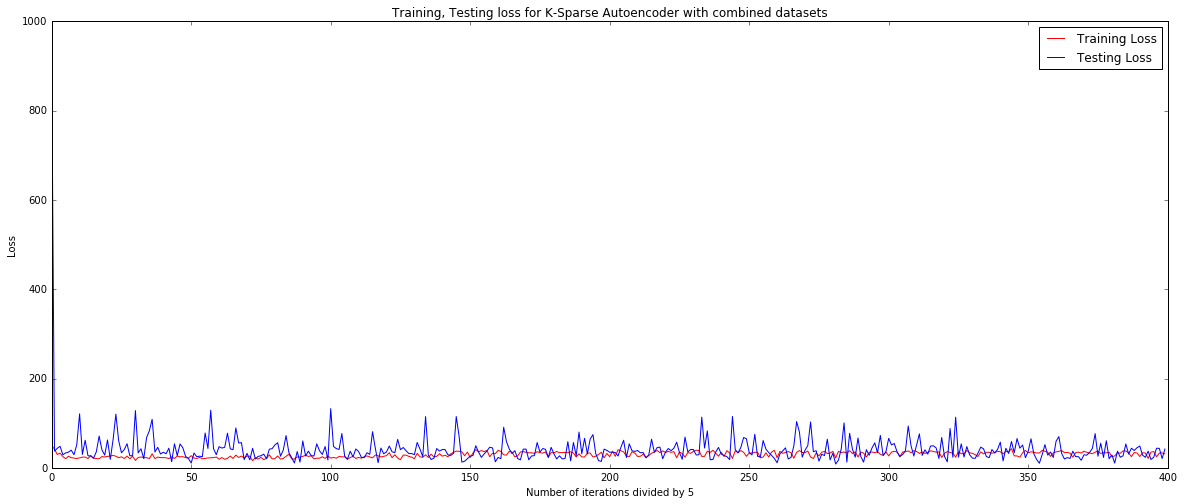

In [13]:
plt.figure(figsize=(20,8))
plt.plot(train_loss,'r')
plt.plot(test_loss,'b')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('Loss')
plt.legend(['Training Loss','Testing Loss'])
plt.title('Training, Testing loss for K-Sparse Autoencoder with combined datasets')

The above plot shows the loss plot over the entire 2000 iterations. The overall flatness is due to the fast convergence our K-Sparse Autoencoder is able to achive. To see the losses decreasing, we need to zoom in to the first 250 iterations and see training and testing separately:

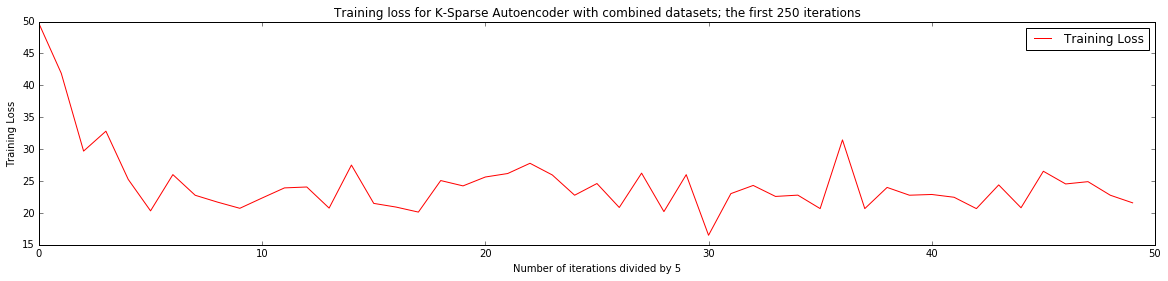

In [15]:
plt.figure(figsize=(20,4))
plt.plot(train_loss[:50],'r')
# plt.plot(test_loss[:50],'b')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('Training Loss')
plt.legend(['Training Loss'])
plt.title('Training loss for K-Sparse Autoencoder with combined datasets; the first 250 iterations')

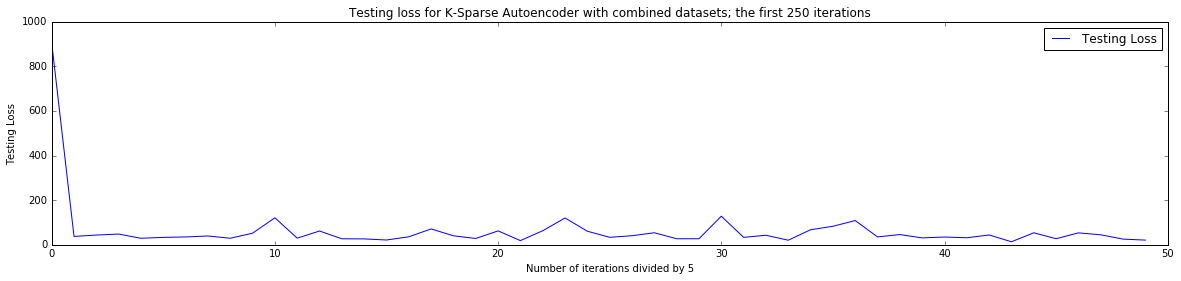

In [16]:
plt.figure(figsize=(20,4))
# plt.plot(train_loss[:50],'r')
plt.plot(test_loss[:50],'b')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('Testing Loss')
plt.legend(['Testing Loss'])
plt.title('Testing loss for K-Sparse Autoencoder with combined datasets; the first 250 iterations')

In [17]:
print 'At the end, the training loss is: ', train_loss[-1]
print 'At the end, the testing loss is: ', test_loss[-1]

At the end, the training loss is:  31.2556304932
At the end, the testing loss is:  41.9548


In [18]:
print 'Average training loss: ', np.mean(train_loss)
print 'Average testing loss: ', np.mean(test_loss)

Average training loss:  29.6054261875
Average testing loss:  42.621


** Comment **

The testing loss started very high at around 900, but as training progress and both encode and decode parameters gets updated, the testing loss immediately dropped to less than 100 after the first 5 iterations (, which corresponds to the first data point on the plot since we collect one loss data point every 5 iterations). 

It can also be seen that training loss started around 60 and settled very fast down to around 20 after the first 250 iterations. Over the long iterations, the testing loss is more oscillatory than the training loss and on average higher than the training loss. This makes sense because training loss tends to be low due to overfitting. 

### Train with Person individual dataset

Training iterations: 2000 iterations (batch_size=1), equivalent to 1 full epoch. 

In [5]:
solver_2 = caffe.SGDSolver(net_root+'/solver_person.prototxt')
save_path_2 = net_root
filename_2 = 'k_sparse_person_data'
train_loss_2, test_loss_2=k_sparse(solver_2,save_path_2,filename_2,niters=2000)

Iteration:  0 Training Loss:  59.6282539368
Iteration:  0 Testing Loss:  311.038
Iteration:  5 Training Loss:  47.3970375061
Iteration:  5 Testing Loss:  43.4254
Iteration:  10 Training Loss:  36.3721351624
Iteration:  10 Testing Loss:  347.723
Iteration:  15 Training Loss:  14.7842950821
Iteration:  15 Testing Loss:  232.198
Iteration:  20 Training Loss:  31.2984027863
Iteration:  20 Testing Loss:  54.4837
Iteration:  25 Training Loss:  28.555185318
Iteration:  25 Testing Loss:  54.4051
Iteration:  30 Training Loss:  22.1926422119
Iteration:  30 Testing Loss:  27.1583
Iteration:  35 Training Loss:  33.4878425598
Iteration:  35 Testing Loss:  78.214
Iteration:  40 Training Loss:  19.6034984589
Iteration:  40 Testing Loss:  50.6473
Iteration:  45 Training Loss:  20.3044281006
Iteration:  45 Testing Loss:  71.244
Iteration:  50 Training Loss:  27.042470932
Iteration:  50 Testing Loss:  49.0042
Iteration:  55 Training Loss:  16.1618347168
Iteration:  55 Testing Loss:  30.4753
Iteration:  

At the end, the training loss is:  15.6676111221
At the end, the testing loss is:  60.3906
Average training loss:  22.5643225789
Average testing loss:  74.8624


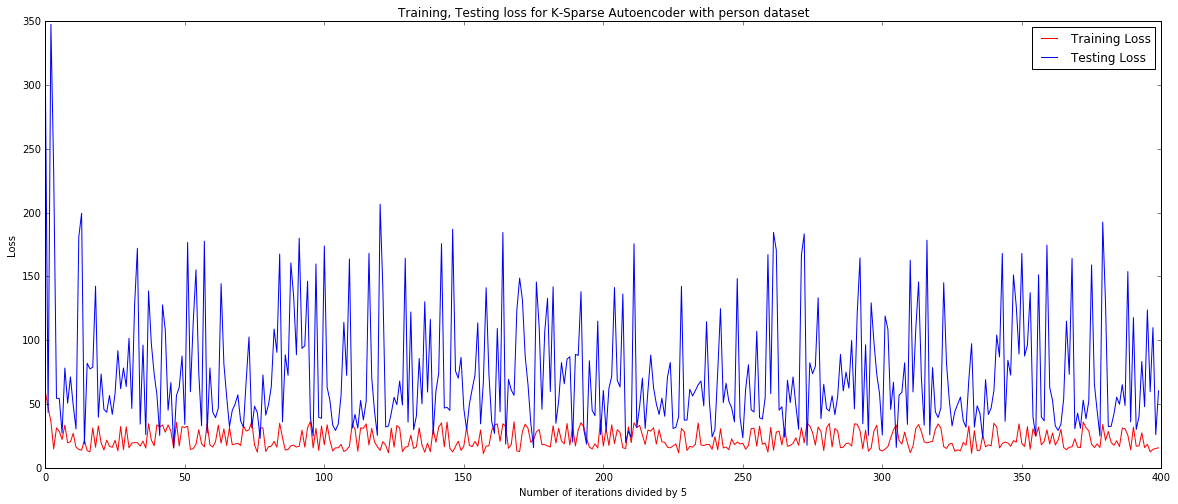

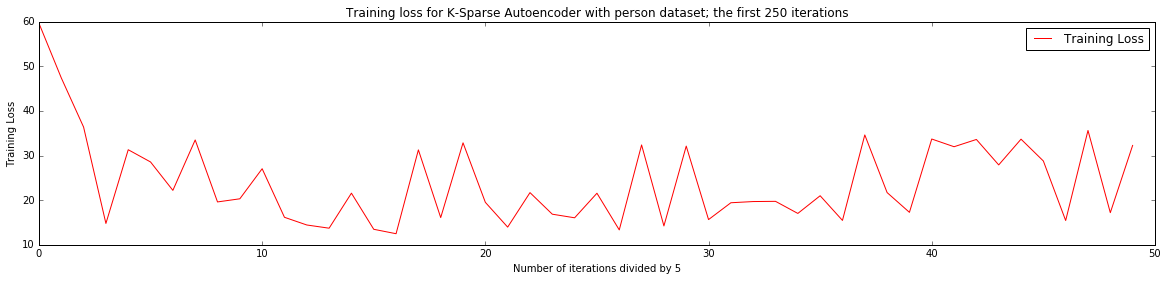

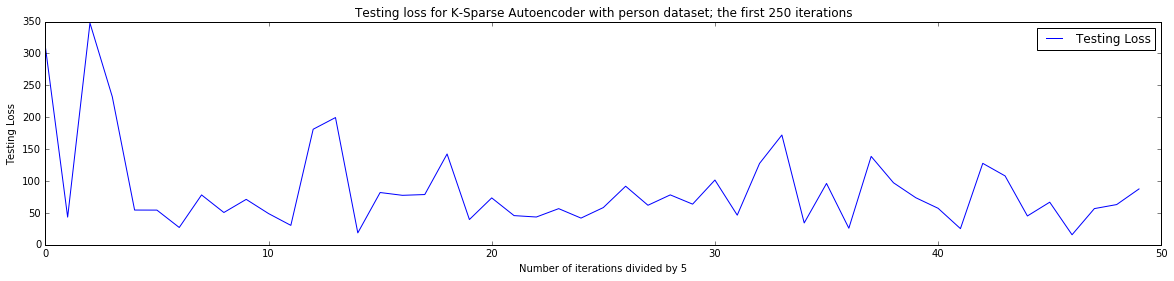

In [19]:
plt.figure(figsize=(20,8))
plt.plot(train_loss_2,'r')
plt.plot(test_loss_2,'b')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('Loss')
plt.legend(['Training Loss','Testing Loss'])
plt.title('Training, Testing loss for K-Sparse Autoencoder with person dataset')

plt.figure(figsize=(20,4))
plt.plot(train_loss_2[:50],'r')
# plt.plot(test_loss[:50],'b')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('Training Loss')
plt.legend(['Training Loss'])
plt.title('Training loss for K-Sparse Autoencoder with person dataset; the first 250 iterations')

plt.figure(figsize=(20,4))
# plt.plot(train_loss[:50],'r')
plt.plot(test_loss_2[:50],'b')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('Testing Loss')
plt.legend(['Testing Loss'])
plt.title('Testing loss for K-Sparse Autoencoder with person dataset; the first 250 iterations')

print 'At the end, the training loss is: ', train_loss_2[-1]
print 'At the end, the testing loss is: ', test_loss_2[-1]

print 'Average training loss: ', np.mean(train_loss_2)
print 'Average testing loss: ', np.mean(test_loss_2)

### Train with Fungus individual dataset

Training iterations: 2000 iterations (batch_size=1), equivalent to 1 full epoch. 

In [6]:
solver_3 = caffe.SGDSolver(net_root+'/solver_fungus.prototxt')
save_path_3 = net_root
filename_3 = 'k_sparse_fungus_data'
train_loss_3, test_loss_3=k_sparse(solver_3,save_path_3,filename_3,niters=2000)

Iteration:  0 Training Loss:  37.9323883057
Iteration:  0 Testing Loss:  1057.45
Iteration:  5 Training Loss:  55.9035758972
Iteration:  5 Testing Loss:  63.8432
Iteration:  10 Training Loss:  36.1140670776
Iteration:  10 Testing Loss:  22.7234
Iteration:  15 Training Loss:  19.3878726959
Iteration:  15 Testing Loss:  24.8808
Iteration:  20 Training Loss:  19.6372756958
Iteration:  20 Testing Loss:  31.8491
Iteration:  25 Training Loss:  17.7866516113
Iteration:  25 Testing Loss:  35.6346
Iteration:  30 Training Loss:  25.8241271973
Iteration:  30 Testing Loss:  41.6051
Iteration:  35 Training Loss:  23.5622406006
Iteration:  35 Testing Loss:  60.9332
Iteration:  40 Training Loss:  24.336309433
Iteration:  40 Testing Loss:  21.1978
Iteration:  45 Training Loss:  19.6282234192
Iteration:  45 Testing Loss:  23.3444
Iteration:  50 Training Loss:  13.4571685791
Iteration:  50 Testing Loss:  30.5993
Iteration:  55 Training Loss:  31.1750240326
Iteration:  55 Testing Loss:  43.0003
Iteration

At the end, the training loss is:  11.0020580292
At the end, the testing loss is:  22.6326
Average training loss:  20.3179508436
Average testing loss:  40.4984


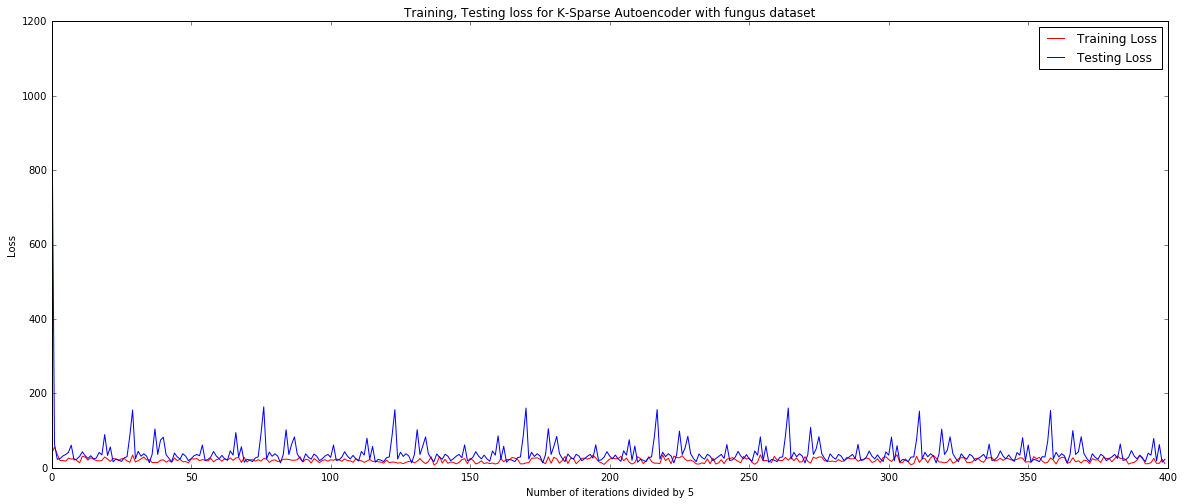

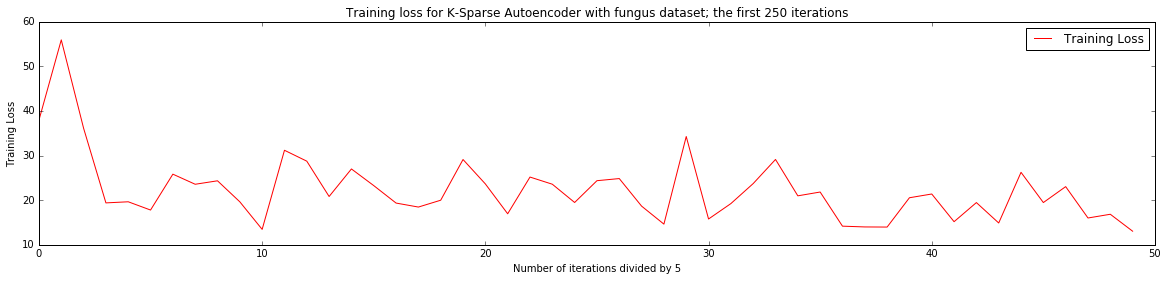

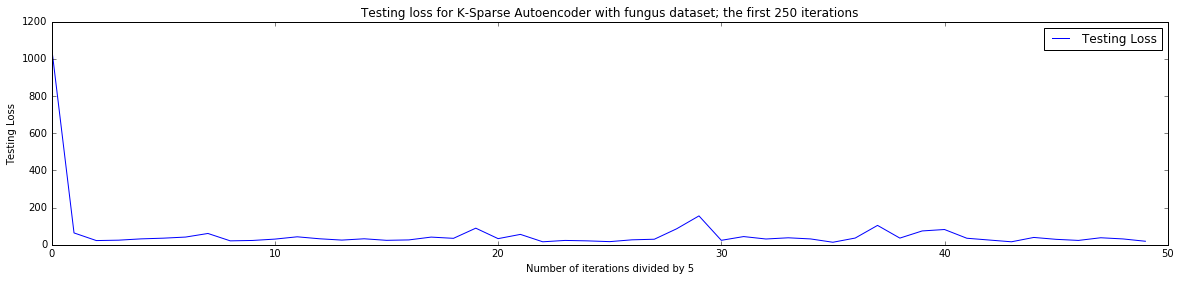

In [20]:
plt.figure(figsize=(20,8))
plt.plot(train_loss_3,'r')
plt.plot(test_loss_3,'b')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('Loss')
plt.legend(['Training Loss','Testing Loss'])
plt.title('Training, Testing loss for K-Sparse Autoencoder with fungus dataset')

plt.figure(figsize=(20,4))
plt.plot(train_loss_3[:50],'r')
# plt.plot(test_loss[:50],'b')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('Training Loss')
plt.legend(['Training Loss'])
plt.title('Training loss for K-Sparse Autoencoder with fungus dataset; the first 250 iterations')

plt.figure(figsize=(20,4))
# plt.plot(train_loss[:50],'r')
plt.plot(test_loss_3[:50],'b')
plt.xlabel('Number of iterations divided by 5')
plt.ylabel('Testing Loss')
plt.legend(['Testing Loss'])
plt.title('Testing loss for K-Sparse Autoencoder with fungus dataset; the first 250 iterations')

print 'At the end, the training loss is: ', train_loss_3[-1]
print 'At the end, the testing loss is: ', test_loss_3[-1]

print 'Average training loss: ', np.mean(train_loss_3)
print 'Average testing loss: ', np.mean(test_loss_3)

## Comparison: Combined Dataset v.s. Separate Datasets

Comparatively, training on a single dataset results in lower training loss (on Fungus avg. training loss is 15.67 and on Person avg. training loss is 11.00 compared to avg training loss 22.56 on the combined dataset.) I think this is because single dataset is more focused and concentrated on one specific category, and thus the autoencoder tends to learn better according to the training data, i.e lower training loss. Training on the combined dataset, on the other hand hence have slightly higher training loss. 

On the other hand, training on the combined dataset will produce the lower testing loss. I think this is because the combined dataset has more expanse and thus enables the training to be more comprehensive. When facing with the testing data, the autoencoder is more familiar with it and hence performs better. On the contrary, training with single dataset makes the autoencoder less capable when facing the testing data. 

# Comparison with K-SVD

Compared to K-SVD, K-Sparse-Autoencoder seems to be able to distinguish from training on combined Dataset to training on single datasets. I think this is mainly because autoencoders in general is a form of neural network; the architecture of neural network in general tends to be more senstive to different data and more responsive. 

## Note:

Since .caffemodel files are very large, I will not submit these files together with the assignment. If you need to see these files, please don't hesitate to contact me via email: tliang37@gatech.edu